# querying the data lake in a jupyter notebook

## prerequisites

make sure you have `pip install presto-python-client` and `pandas` and `matplotlib` installed.
you may do that via `pip install <name from above>`

In [156]:
import prestodb
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [83]:
conn=prestodb.dbapi.connect(
    host='presto.apps.eu.idealo.com',
    port=443, user='aishwarya.kumar',
    catalog='hive',
    http_scheme='https',
    schema='default',)

In [84]:
conn

## creating a cursor object instance

In [85]:
# create the cursor
cur = conn.cursor()
# cursor objects functions and attributes
[thing for thing in dir(cur) if '_' not in thing]

['arraysize',
 'cancel',
 'close',
 'connection',
 'description',
 'execute',
 'executemany',
 'fetchall',
 'fetchmany',
 'fetchone',
 'genall',
 'rowcount',
 'setinputsizes',
 'setoutputsize',
 'stats']

## exploring the schemas and tables

In [86]:
#schema either in double quotes or without quotes!
cur.execute('''
SHOW TABLES from "dl_inventory_intelligence_prod"
''')
records = cur.fetchall()
list(records)

[['fake_shop'],
 ['feed_quality_layer'],
 ['kpi_product'],
 ['kpi_product_offers'],
 ['kpi_shop'],
 ['merchant_dk'],
 ['pareto_clusters'],
 ['priceapi_processed'],
 ['tidy_category_tree']]

## creating a cursor and querying

query can be highlighted in markdown code blocks (between triple backtics \`\`\`) for better readability
```sql
SELECT * 
FROM "dl_dwh_prod"."so_facts"
WHERE random(1000) = 1
limit 1000
```

## storing the results in a dataframe

In [519]:
import pandas as pd

In [520]:
cur.execute('''
WITH tidy_tree AS (
 SELECT distinct
  category_id,root_category_name,sub_category_name_de,category_name_de
  from dl_inventory_intelligence_prod.tidy_category_tree
  )
  
SELECT
date_format(date(date),'%Y-%m-%d') AS  day,
hour,
root_category_name,
sub_category_name_de,
sum(pageimpression_oop) as pageimpression_oop,
sum(leadouts_oop)+ sum(checkouts_oop) as LOCO_OOP
FROM dl_inventory_intelligence_prod.kpi_product a 
join tidy_tree t on a.category_id=t.category_id
where site like '%idealo.de%' and date < '2021-10-01'
group by 1,2,3,4
order by 1,2,3,4
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

Total rows are:  1717396


In [2]:
#getting colnames from description, which is a list of columns with header and their entries
from dateutil import parser
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
df = pd.DataFrame(records, columns=colnames)
#df['date'] = pd.to_datetime(df['year_week'], format='%Y-%w')

NameError: name 'cur' is not defined

In [522]:
cur.execute('''
WITH sub_category as (
SELECT root_category_name, sub_category_id, sub_category_name_de, category_id
FROM dl_inventory_intelligence_prod.tidy_category_tree)

SELECT
date_format(date_utc,'%Y-%m-%d') AS  day,
hour,
root_category_name,
sub_category_name_de,
COUNT(DISTINCT trace_uuid) as pageimpression_oop
FROM
dl_dwh_prod.isg_refined
LEFT JOIN sub_category on isg_refined.category_id = sub_category.category_id
WHERE
date_utc BETWEEN date('2019-01-01') AND date('2019-06-30')
AND botstatus = 'user'
AND (status = 200 OR media = 'app')
AND page_type IN ('pageimpression', 'appaction')
AND (script_name NOT like '/offerpage/context/local/refresh/%' OR
(media = 'app' AND script_name IS NULL))
AND idealo_host LIKE '%idealo.de'
AND page_template = 'OffersOfProduct'
GROUP BY 1, 2, 3,4
''') # this was a multiline string.
records = cur.fetchall()
print("Total rows are: ", len(records))

from dateutil import parser
colnames = [col[0] for col in cur.description]
colnames[0:5]
#creating dataframe
data_2019 = pd.DataFrame(records, columns=colnames)



Total rows are:  361007


In [1]:
#data_2019=pd.read_csv('2019_weekly_data.csv') 
#data_2019=data_2019.rename(columns={"pi": "pageimpression_oop"})
#data_2019['date'] = pd.to_datetime(data_2019['year_week'],format='%Y-%w')
frames = [df, data_2019]
result = pd.concat(frames)
result=result.drop_duplicates()
result = result.sort_values(by=["day","hour"]) # include hour
result=result.astype({'day': 'datetime64[ns]'})

NameError: name 'df' is not defined

In [526]:
result.tail()

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
1717391,2021-09-30,23,Tierbedarf,Pferd,NaN,10.0
1717392,2021-09-30,23,Tierbedarf,Terraristik,NaN,1.0
1717393,2021-09-30,23,Tierbedarf,Tiergesundheit,NaN,22.0
1717394,2021-09-30,23,Tierbedarf,Vogel,NaN,10.0
1717395,2021-09-30,23,Tierbedarf,Wildtier,NaN,0.0


In [527]:
import pandas as pd
from datetime import date
start_date = date(2019, 1, 1)
end_date = date(2021, 9, 30)
delta = end_date - start_date
period = delta.days
df_dates = pd.DataFrame({'day':pd.date_range(start_date, periods=period)})
print(df_dates.shape)
df_hours = pd.DataFrame({'hour':[*range(0,24,1)]})
print(df_hours.shape)

(1003, 1)
(24, 1)


In [528]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

overall_df=cartesian_product_basic(df_dates, df_hours)

In [529]:
final_result = pd.merge(overall_df, result, how='left', on=['day', 'hour'])
final_result.tail(50)

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
2076287,2021-09-29,23,Elektroartikel,TV & Sat,1501.0,514.0
2076288,2021-09-29,23,Elektroartikel,Telekommunikation,4586.0,1720.0
2076289,2021-09-29,23,Essen & Trinken,Getränke,457.0,231.0
2076290,2021-09-29,23,Essen & Trinken,Kaffee & Espresso,23.0,11.0
2076291,2021-09-29,23,Essen & Trinken,Kaffeekapseln & Pads,18.0,2.0
2076292,2021-09-29,23,Essen & Trinken,Lebensmittel,30.0,19.0
2076293,2021-09-29,23,Essen & Trinken,Süßigkeiten & Knabbereien,33.0,31.0
2076294,2021-09-29,23,Essen & Trinken,Tee,15.0,2.0
2076295,2021-09-29,23,Gaming & Spielen,Gaming Zubehör,335.0,113.0
2076296,2021-09-29,23,Gaming & Spielen,Modellbau,581.0,40.0


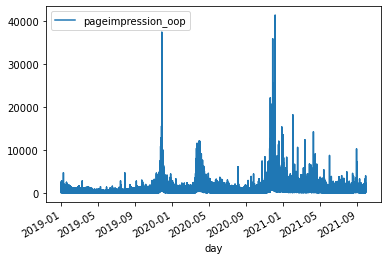

In [602]:
subset=final_result[(final_result.sub_category_name_de=="Spielekonsole")]
subset.plot( 'day' , 'pageimpression_oop' )
subset = subset.sort_values(by=["day","hour"])
#y=subset[['day','pageimpression_oop']].set_index("day")
#y=subset[['date','pageimpression_oop']].set_index("date").to_period("M")

In [603]:
subset.tail(50)

,day,hour,root_category_name,sub_category_name_de,pageimpression_oop,LOCO_OOP
2072050,2021-09-27,22,Gaming & Spielen,Spielekonsole,739.0,200.0
2072135,2021-09-27,23,Gaming & Spielen,Spielekonsole,366.0,120.0
2072220,2021-09-28,0,Gaming & Spielen,Spielekonsole,230.0,73.0
2072306,2021-09-28,1,Gaming & Spielen,Spielekonsole,141.0,36.0
2072390,2021-09-28,2,Gaming & Spielen,Spielekonsole,235.0,26.0
2072475,2021-09-28,3,Gaming & Spielen,Spielekonsole,368.0,15.0
2072561,2021-09-28,4,Gaming & Spielen,Spielekonsole,817.0,20.0
2072646,2021-09-28,5,Gaming & Spielen,Spielekonsole,1174.0,33.0
2072731,2021-09-28,6,Gaming & Spielen,Spielekonsole,1340.0,41.0
2072818,2021-09-28,7,Gaming & Spielen,Spielekonsole,1442.0,84.0


In [604]:
subset[subset.pageimpression_oop.isnull()]
subset['pageimpression_oop'].fillna((subset['pageimpression_oop'].mean()), inplace=True)
#subset['pageimpression_oop'] = subset['pageimpression_oop'].fillna(0)

In [605]:
subset['date'] = pd.to_datetime(subset['day'])
timestamp_s = subset['date'].map(pd.Timestamp.timestamp)
hour = subset["hour"]
weekday = subset['date'].map(lambda x: x.weekday())
subset = subset.drop(["day", "hour", "date", "sub_category_name_de", "root_category_name","LOCO_OOP"], axis=1)

subset.head()

,pageimpression_oop
20,691.0
83,518.0
181,383.0
265,250.0
359,187.0


In [606]:
indicator = pd.get_dummies(weekday)
indicator.rename(columns={0 : 'mo', 1 : 'tu', 2: 'We', 3 : 'th', 4 : 'fr', 5 : 'sa', 6 : 'su'}, inplace=True)
indicator.head(10)
subset = pd.concat([subset, indicator], axis=1)
subset



,pageimpression_oop,mo,tu,We,th,fr,sa,su
20,691.0,0,1,0,0,0,0,0
83,518.0,0,1,0,0,0,0,0
181,383.0,0,1,0,0,0,0,0
265,250.0,0,1,0,0,0,0,0
359,187.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2075949,2482.0,0,0,1,0,0,0,0
2076038,1744.0,0,0,1,0,0,0,0
2076124,1260.0,0,0,1,0,0,0,0
2076211,673.0,0,0,1,0,0,0,0


In [607]:
import numpy as np
day = 24*60*60
year = 365*day
subset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
subset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

subset['day sin'] = np.sin(hour * (2 * np.pi / 24))
subset['day cos'] = np.cos(hour * (2 * np.pi / 24))

In [608]:
column_indices = {name: i for i, name in enumerate(subset.columns)}

In [609]:
n = len(subset)
train_df_ = subset[0:int(n*0.7)]
val_df_ = subset[int(n*0.7):int(n*0.9)]
test_df_ = subset[int(n*0.9):]

num_features = subset.shape[1]

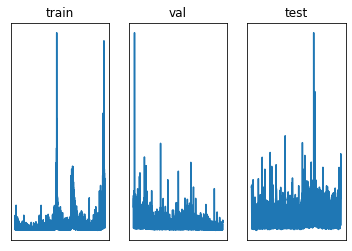

In [610]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.subplot(1,3,1)
plt.plot(train_df_.pageimpression_oop)
#plt.plot(train_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("train")
plt.subplot(1,3,2)
plt.plot(val_df_.pageimpression_oop)
#plt.plot(val_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("val")
plt.subplot(1,3,3)
plt.plot(test_df_.pageimpression_oop)
#plt.plot(test_df_.LOCO_OOP)
plt.xticks([])
plt.yticks([])
plt.title("test")
plt.show()

In [611]:
train_mean = train_df_.mean()
train_std = train_df_.std()

def normalize(x):
    return (x - train_mean) / train_std

train_df = normalize(train_df_)
val_df = normalize(val_df_)
test_df = normalize(test_df_)

In [612]:
train_df

,pageimpression_oop,mo,tu,We,th,fr,sa,su,Year sin,Year cos,day sin,day cos
20,-0.337526,-0.407543,2.439376,-0.409818,-0.407741,-0.407543,-0.407543,-0.407543,0.282525,1.470165,0.000093,1.413730
83,-0.419568,-0.407543,2.439376,-0.409818,-0.407741,-0.407543,-0.407543,-0.407543,0.282525,1.470165,0.366149,1.365549
181,-0.483589,-0.407543,2.439376,-0.409818,-0.407741,-0.407543,-0.407543,-0.407543,0.282525,1.470165,0.707260,1.224288
265,-0.546662,-0.407543,2.439376,-0.409818,-0.407741,-0.407543,-0.407543,-0.407543,0.282525,1.470165,1.000178,0.999576
359,-0.576539,-0.407543,2.439376,-0.409818,-0.407741,-0.407543,-0.407543,-0.407543,0.282525,1.470165,1.224942,0.706725
...,...,...,...,...,...,...,...,...,...,...,...,...
1448929,1.419028,-0.407543,-0.409917,2.439964,-0.407741,-0.407543,-0.407543,-0.407543,-0.402586,1.439470,-0.707074,1.224288
1449018,0.230129,-0.407543,-0.409917,2.439964,-0.407741,-0.407543,-0.407543,-0.407543,-0.402586,1.439470,-0.365964,1.365549
1449106,-0.160163,-0.407543,-0.409917,-0.409818,2.452389,-0.407543,-0.407543,-0.407543,-0.379649,1.446436,0.000093,1.413730
1449193,-0.288680,-0.407543,-0.409917,-0.409818,2.452389,-0.407543,-0.407543,-0.407543,-0.379649,1.446436,0.366149,1.365549


In [613]:
"""
This class is extracted from the following tutorial:
https://www.tensorflow.org/tutorials/structured_data/time_series
See this tutorial for a detailed explanation.
"""
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, plot_col, model=None, max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                edgecolors="k",
                label="Labels",
                c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    edgecolors="k",
                    label="Predictions",
                    c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


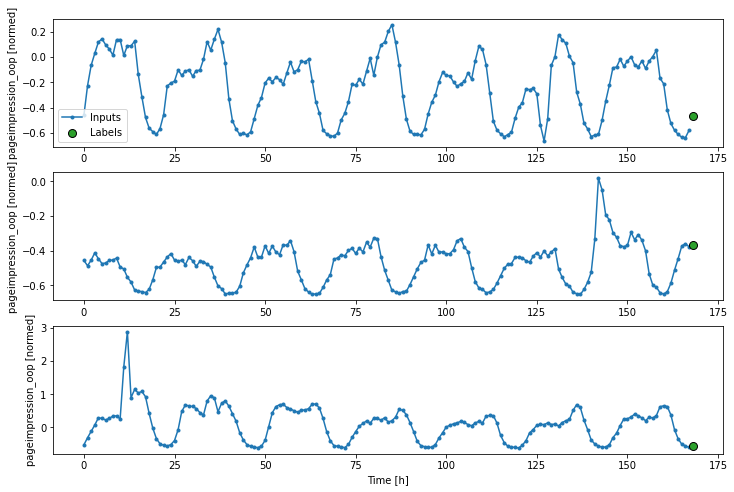

In [614]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
#from window_helper import WindowGenerator
window_generator = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df, input_width=7*24, label_width=1, shift=1, label_columns=['pageimpression_oop'])
window_generator
# show three samples from the window generator
window_generator.plot(plot_col='pageimpression_oop', max_subplots=3)

In [615]:
window_generator

Total window size: 169
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168]
Label column name(s): ['pageimpression_oop']

In [616]:
for example_inputs, example_labels in window_generator.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 168, 12)
Labels shape (batch, time, features): (32, 1, 1)


In [617]:
train_df.count()

pageimpression_oop    16849
mo                    16849
tu                    16849
We                    16849
th                    16849
fr                    16849
sa                    16849
su                    16849
Year sin              16849
Year cos              16849
day sin               16849
day cos               16849
dtype: int64

In [618]:
single_step_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=1, label_width=1, shift=1,
    label_columns=['pageimpression_oop'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

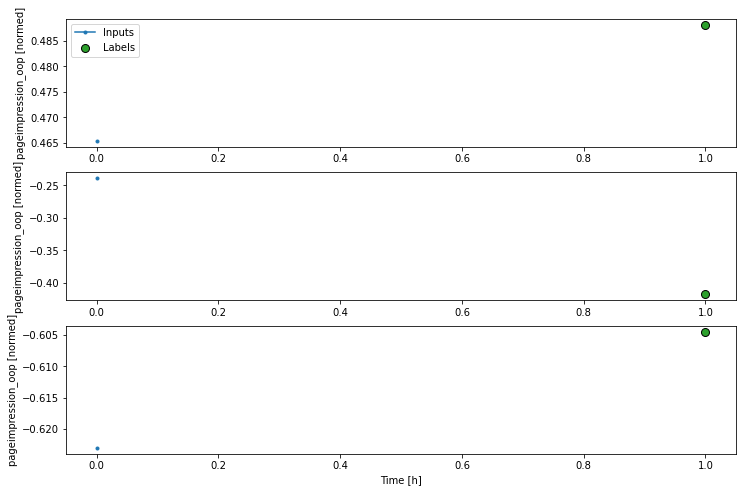

In [619]:
single_step_window.plot(plot_col='pageimpression_oop', max_subplots=3)

In [620]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [621]:
baseline = Baseline(label_index=column_indices['pageimpression_oop'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

train_performance = {}
val_performance = {}
performance = {}
train_performance['Baseline'] = baseline.evaluate(single_step_window.train)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

151/151 [==============================] - 0s 1ms/step - loss: 0.2159 - mean_absolute_error: 0.1917 - mean_absolute_percentage_error: 136.6022


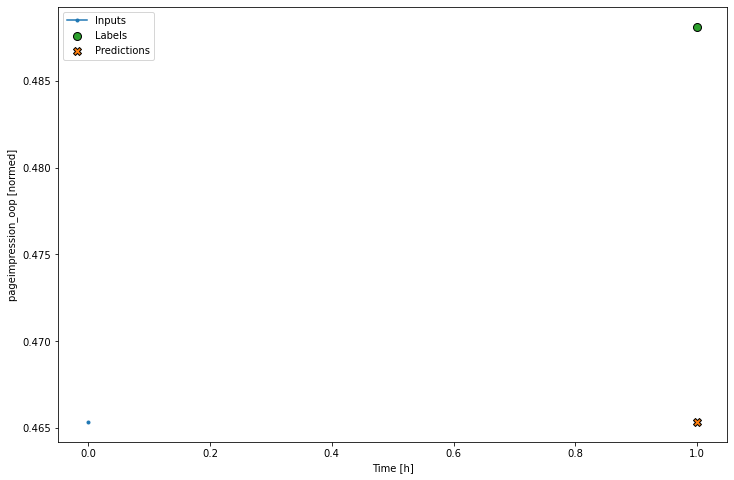

In [622]:
single_step_window.plot(plot_col='pageimpression_oop', model=baseline)

In [623]:
wide_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=24, label_width=24, shift=1,
    label_columns=['pageimpression_oop'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['pageimpression_oop']

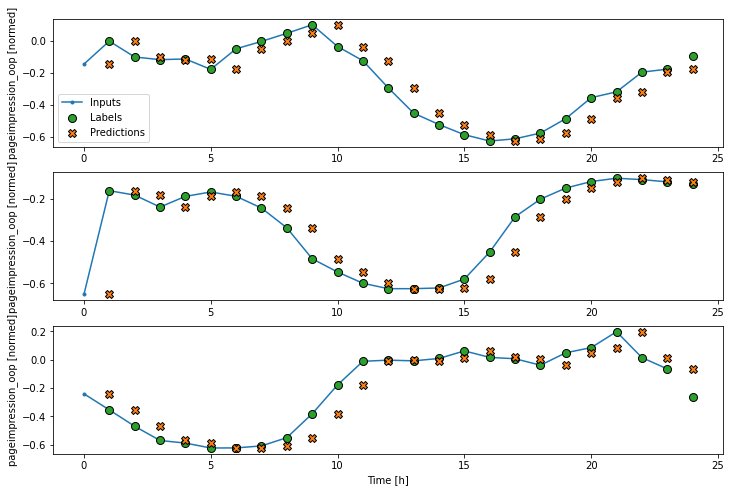

In [624]:
wide_window.plot(model=baseline, plot_col='pageimpression_oop', max_subplots=3)

In [625]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [626]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 12)
Output shape: (32, 1, 1)


In [627]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [628]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['pageimpression_oop']

In [629]:
history = compile_and_fit(linear, single_step_window)

train_performance['Linear'] = linear.evaluate(single_step_window.train)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
527/527 [==============================] - 2s 2ms/step - loss: 2.7399 - mean_absolute_error: 1.1588 - mean_absolute_percentage_error: 1111.4731 - val_loss: 1.1782 - val_mean_absolute_error: 0.7532 - val_mean_absolute_percentage_error: 447.7672
Epoch 2/20
527/527 [==============================] - 1s 2ms/step - loss: 1.0484 - mean_absolute_error: 0.5825 - mean_absolute_percentage_error: 491.4965 - val_loss: 0.4548 - val_mean_absolute_error: 0.4030 - val_mean_absolute_percentage_error: 186.4240
Epoch 3/20
527/527 [==============================] - 1s 2ms/step - loss: 0.5805 - mean_absolute_error: 0.3914 - mean_absolute_percentage_error: 372.0880 - val_loss: 0.2865 - val_mean_absolute_error: 0.2973 - val_mean_absolute_percentage_error: 147.9461 0.5829 - mean_absolute_error: 0.3922 - mean_absolute_percentage_error: 372.80
Epoch 4/20
527/527 [==============================] - 1s 2ms/step - loss: 0.3556 - mean_absolute_error: 0.3033 - mean_absolute_percentage_error: 293.7464 - val

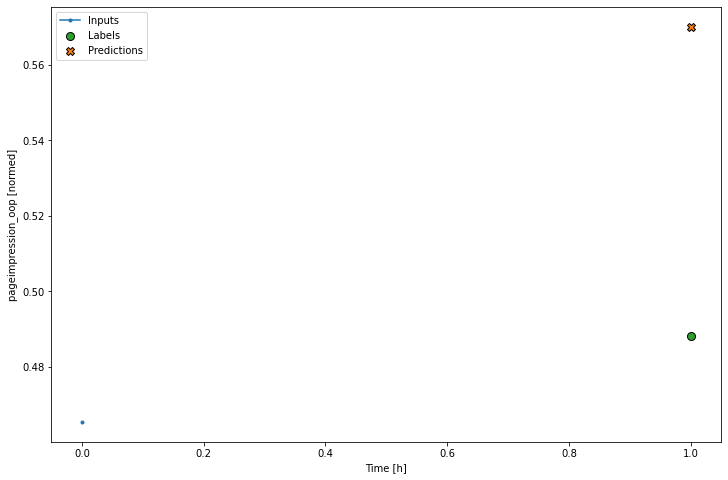

In [630]:
single_step_window.plot(plot_col='pageimpression_oop', model=linear)

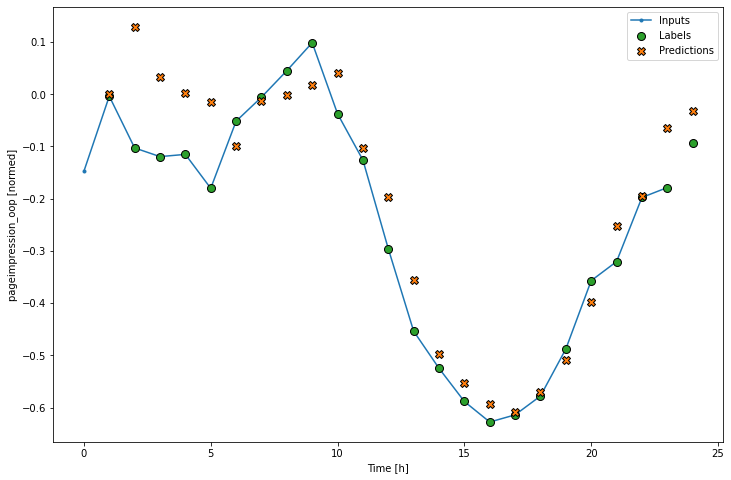

In [631]:
wide_window.plot(model=linear, plot_col='pageimpression_oop', max_subplots=1)

In [634]:
#14 days prediction
OUT_STEPS = 24*14

multi_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df, input_width=24*42, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['pageimpression_oop'])

multi_window

Total window size: 1344
Input indices: [   0    1    2 ... 1005 1006 1007]
Label indices: [1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021
 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035
 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049
 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063
 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077
 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091
 1092 1093 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105
 1106 1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119
 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133
 1134 1135 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147
 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161
 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175
 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 11

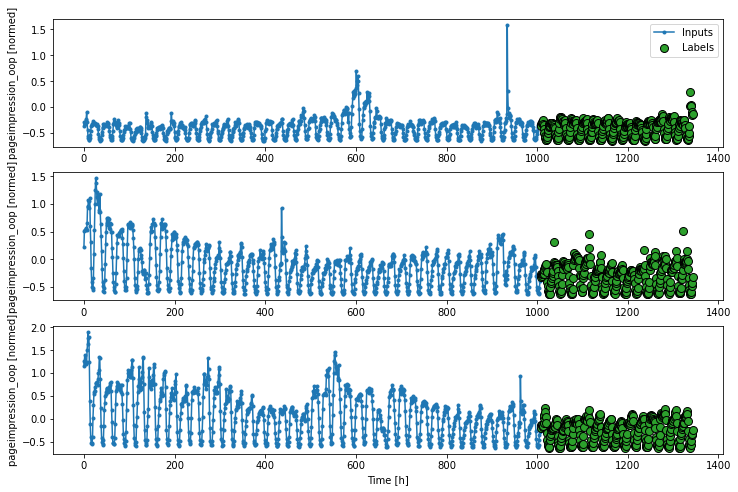

In [635]:
multi_window.plot(plot_col='pageimpression_oop', max_subplots=3)

109/109 [==============================] - 0s 3ms/step - loss: 1.2447 - mean_absolute_error: 0.8573


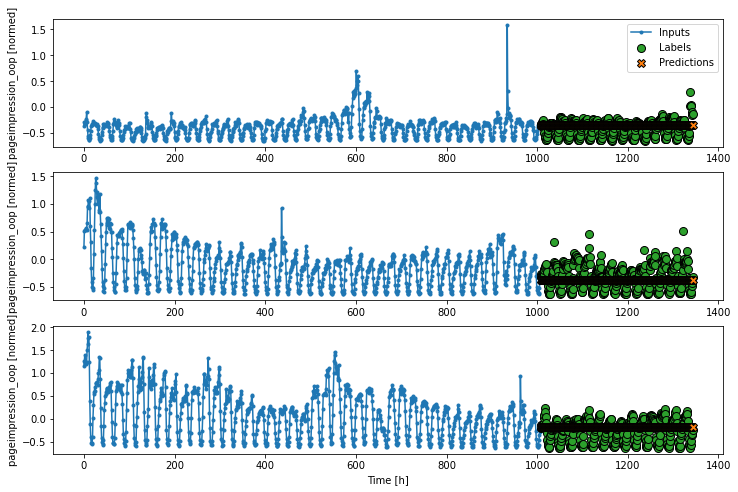

In [636]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_train_performance={}
multi_performance = {}

multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

multi_window.plot(plot_col='pageimpression_oop', model=last_baseline, max_subplots=3)


109/109 [==============================] - 0s 3ms/step - loss: 0.1945 - mean_absolute_error: 0.2859 - mean_absolute_percentage_error: 205.9565


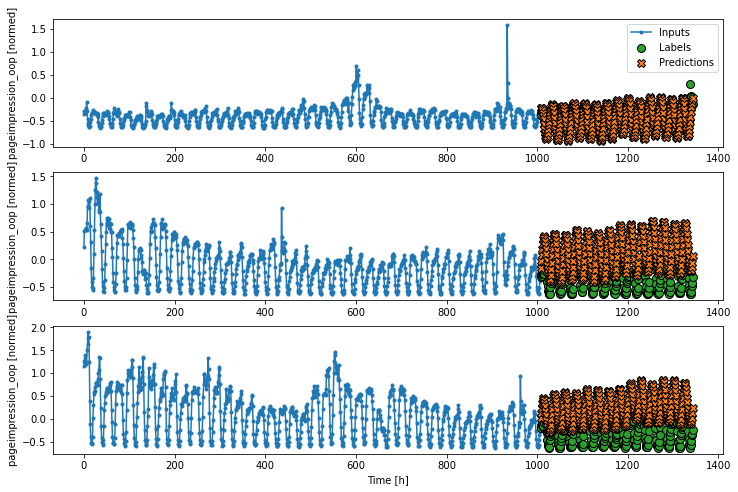

In [637]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Linear'] = multi_linear_model.evaluate(multi_window.train)
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_linear_model, max_subplots=3)

109/109 [==============================] - 1s 6ms/step - loss: 0.2436 - mean_absolute_error: 0.3301 - mean_absolute_percentage_error: 286.3716


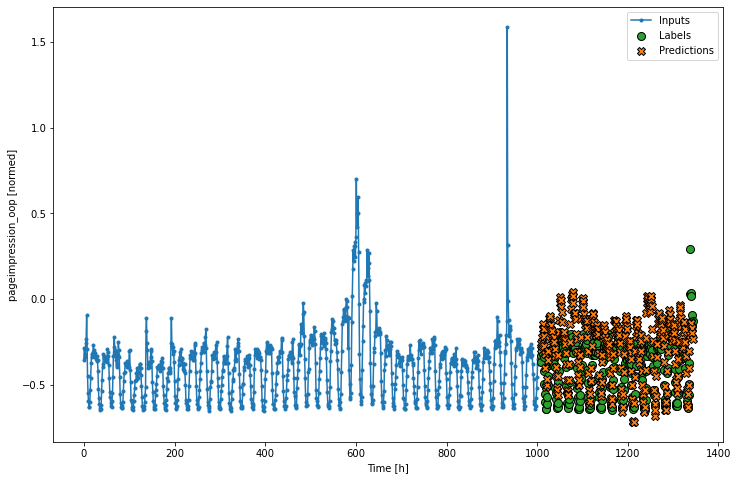

In [638]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Dense'] = multi_dense_model.evaluate(multi_window.train)
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_dense_model)

109/109 [==============================] - 1s 5ms/step - loss: 0.3801 - mean_absolute_error: 0.4237 - mean_absolute_percentage_error: 337.4740


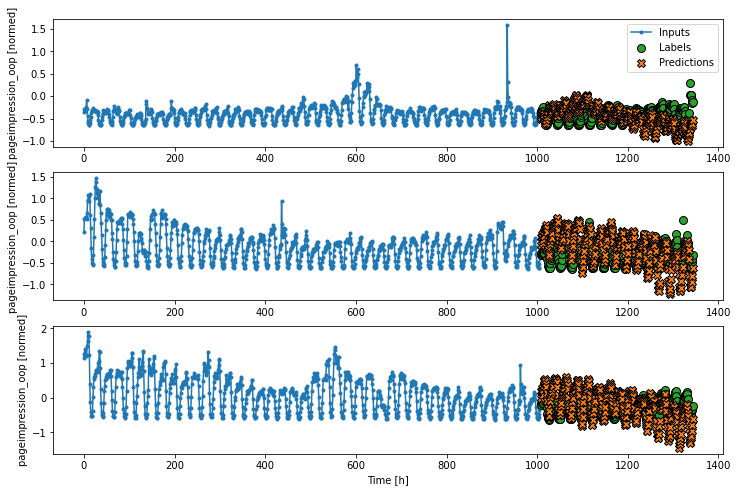

In [640]:
#Read about CONV_WIDTH???
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_conv_model, max_subplots=3)

109/109 [==============================] - 5s 45ms/step - loss: 1.2105 - mean_absolute_error: 0.7062 - mean_absolute_percentage_error: 510.3441


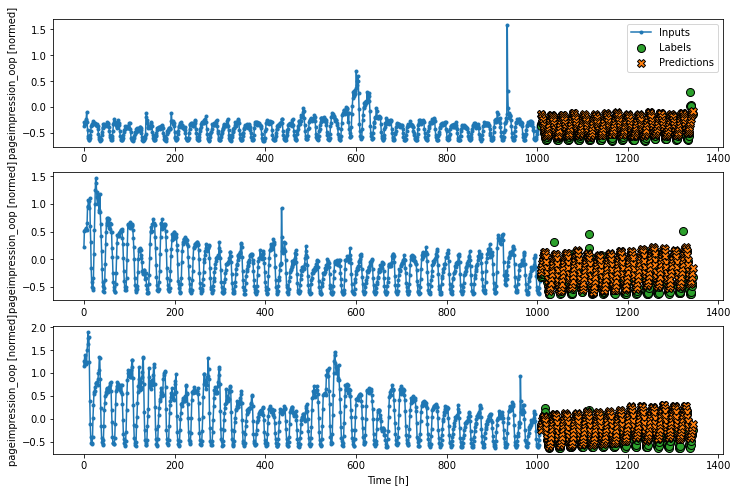

In [641]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_lstm_model, max_subplots=3)

109/109 [==============================] - 3s 27ms/step - loss: 0.3623 - mean_absolute_error: 0.4369 - mean_absolute_percentage_error: 357.0377


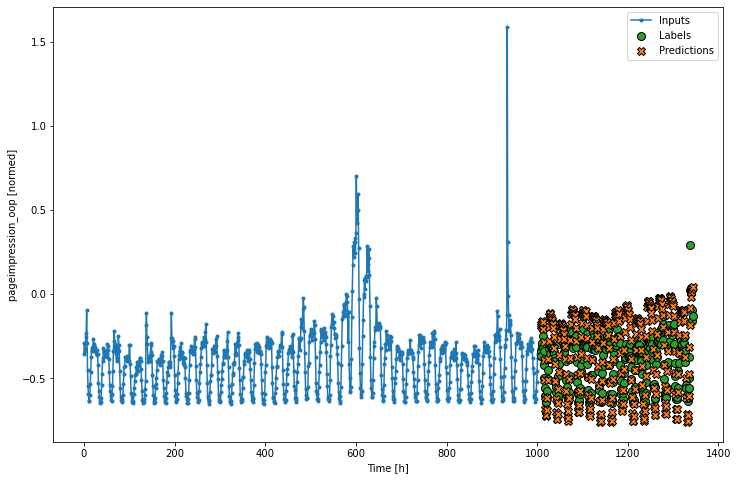

In [643]:
multi_simpleRNN_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_simpleRNN_model, multi_window)

IPython.display.clear_output()
#multi_train_performance = {}
multi_train_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.train)
multi_val_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.val)
multi_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_simpleRNN_model)

In [454]:
multi_train_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train)
multi_train_performance['Conv'] = multi_conv_model.evaluate(multi_window.train)
multi_train_performance['Linear'] = multi_linear_model.evaluate(multi_window.train)
multi_train_performance['Last'] = last_baseline.evaluate(multi_window.train)

451/451 [==============================] - 2s 4ms/step - loss: 2.0770 - mean_absolute_error: 0.9559


93/93 [==============================] - 3s 28ms/step - loss: 0.3902 - mean_absolute_error: 0.4428 - mean_absolute_percentage_error: 206.2552


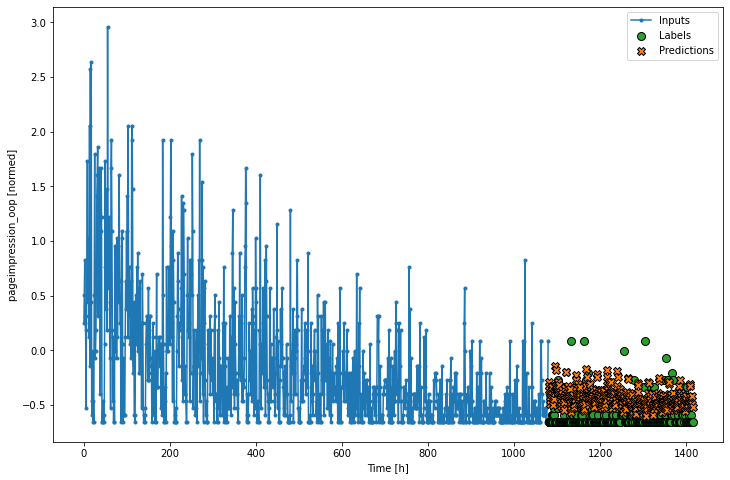

In [201]:
IPython.display.clear_output()
multi_train_performance = {}
multi_train_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.train)
multi_val_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.val)
multi_performance['simpleRNN'] = multi_simpleRNN_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(plot_col='pageimpression_oop', model=multi_simpleRNN_model)

In [385]:
multi_train_performance #old

{'Last': [2.079572916030884, 0.9610003232955933],
 'Linear': [0.6921363472938538, 0.5391139984130859, 218.66717529296875],
 'Dense': [0.45901721715927124, 0.39887723326683044, 197.34768676757812],
 'Conv': [0.36838671565055847, 0.37202638387680054, 178.80581665039062],
 'LSTM': [0.3293662667274475, 0.34435850381851196, 167.0612335205078],
 'simpleRNN': [0.6679900288581848, 0.5577797889709473, 218.89202880859375]}

In [575]:
multi_train_performance

{'Last': [2.072458505630493, 0.954832911491394],
 'Linear': [0.6849420070648193, 0.5361291170120239, 242.9811248779297],
 'Dense': [0.45523732900619507, 0.4017925560474396, 219.51304626464844],
 'Conv': [0.3650265038013458, 0.36228030920028687, 197.23033142089844],
 'LSTM': [0.3359794020652771, 0.3484703600406647, 188.94613647460938],
 'simpleRNN': [0.46258819103240967, 0.4236924946308136, 192.2715606689453]}

In [305]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

93/93 [==============================] - 5s 48ms/step - loss: 0.3839 - mean_absolute_error: 0.4345 - mean_absolute_percentage_error: 201.0133


In [386]:
multi_val_performance #old

{'Last': [1.3847413063049316, 0.8626861572265625],
 'Linear': [0.3635760545730591, 0.44706955552101135, 273.3882141113281],
 'Dense': [0.32680392265319824, 0.3899780809879303, 201.76222229003906],
 'Conv': [0.29640212655067444, 0.3801604211330414, 217.54983520507812],
 'LSTM': [0.30448099970817566, 0.3805762231349945, 192.81419372558594],
 'simpleRNN': [0.35112330317497253, 0.4449649453163147, 210.12313842773438]}

In [576]:
multi_val_performance

{'Last': [1.5602366924285889, 0.9298591017723083],
 'Linear': [0.451977401971817, 0.5044007897377014, 297.22161865234375],
 'Dense': [0.4034993350505829, 0.4526031017303467, 238.95945739746094],
 'Conv': [0.3599136769771576, 0.42785772681236267, 268.5997619628906],
 'LSTM': [0.49092334508895874, 0.4817710518836975, 275.61474609375],
 'simpleRNN': [0.457427054643631, 0.48888635635375977, 231.49647521972656]}

In [645]:
multi_val_performance

{'Last': [1.2447187900543213, 0.8573353290557861],
 'Linear': [0.19449327886104584, 0.2859165370464325, 205.95645141601562],
 'Dense': [0.24361364543437958, 0.3300769627094269, 286.3715515136719],
 'Conv': [0.38009804487228394, 0.42369338870048523, 337.4740295410156],
 'LSTM': [1.2104500532150269, 0.7061795592308044, 510.3441467285156],
 'simpleRNN': [0.36234843730926514, 0.43685516715049744, 357.0376892089844]}

In [577]:
train_mae

[0.9610003232955933,
 0.5391139984130859,
 0.39887723326683044,
 0.37202638387680054,
 0.34435850381851196,
 0.5577797889709473]

In [578]:
val_mae

[0.8626861572265625,
 0.44706955552101135,
 0.3899780809879303,
 0.3801604211330414,
 0.3805762231349945,
 0.4449649453163147]

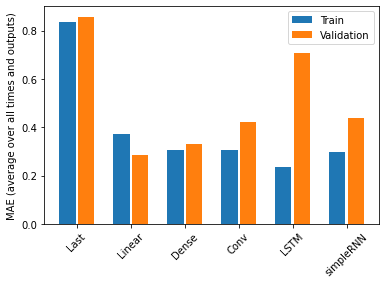

In [644]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_dense_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in multi_train_performance.values()]
val_mae = [v[metric_index] for v in multi_val_performance.values()]

plt.bar(x - 0.17, train_mae, width, label='Train')
plt.bar(x + 0.17, val_mae, width, label='Validation')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [580]:
from sklearn.metrics import mean_absolute_percentage_error

In [581]:
predict_df = normalize(test_df_.iloc[:45*24])
actual_df = test_df_.iloc[45*24:59*24].pageimpression_oop

In [582]:
predict_np = predict_df.to_numpy()
predict_np = np.expand_dims(predict_np, axis=0)
predict_np.shape

(1, 1080, 12)

In [583]:
predict_df.head()

,pageimpression_oop,mo,tu,We,th,fr,sa,su,Year sin,Year cos,day sin,day cos
1878463,0.659536,-0.409438,-0.409122,-0.409228,-0.408386,-0.409753,2.459937,-0.405222,-0.105645,-1.360623,-0.944511,-0.940675
1878548,0.268184,-0.409438,-0.409122,-0.409228,-0.408386,-0.409753,2.459937,-0.405222,-0.105645,-1.360623,-1.167293,-0.644074
1878634,1.703143,-0.409438,-0.409122,-0.409228,-0.408386,-0.409753,2.459937,-0.405222,-0.105645,-1.360623,-1.307340,-0.298674
1878720,4.377386,-0.409438,-0.409122,-0.409228,-0.408386,-0.409753,2.459937,-0.405222,-0.105645,-1.360623,-1.355108,0.071985
1878805,3.594681,-0.409438,-0.409122,-0.409228,-0.408386,-0.409753,2.459937,-0.405222,-0.105645,-1.360623,-1.307340,0.442645


In [584]:
prediction_np = multi_conv_model.predict(predict_np)
prediction_np

array([[[1.8352185, 1.8352185, 1.8352185, ..., 1.8352185, 1.8352185,
         1.8352185],
        [1.6966724, 1.6966724, 1.6966724, ..., 1.6966724, 1.6966724,
         1.6966724],
        [1.9273018, 1.9273018, 1.9273018, ..., 1.9273018, 1.9273018,
         1.9273018],
        ...,
        [0.836736 , 0.836736 , 0.836736 , ..., 0.836736 , 0.836736 ,
         0.836736 ],
        [0.7734052, 0.7734052, 0.7734052, ..., 0.7734052, 0.7734052,
         0.7734052],
        [0.9238711, 0.9238711, 0.9238711, ..., 0.9238711, 0.9238711,
         0.9238711]]], dtype=float32)

In [585]:
def scale_back(x):
    return x * train_std[0] + train_mean[0]

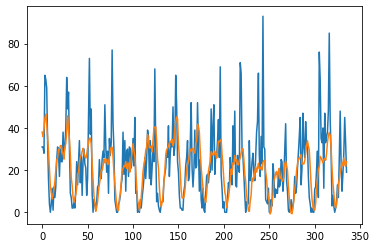

In [586]:
preds = scale_back(prediction_np[0,:,0])
plt.plot(actual_df.to_numpy())
plt.plot(preds)

In [587]:
mean_absolute_percentage_error(actual_df.to_numpy(), preds)

1581896821137798.8

In [588]:
weekly_total_actual = np.sum(actual_df.to_numpy())
weekly_total_predicted = np.sum(preds)

In [589]:
mean_absolute_percentage_error([weekly_total_actual], [weekly_total_predicted])

0.0387338115212053